### jupyter notebook for the exploratory data analysis of the onet data

author: Jan Jörg
date: 14.03.2024

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import json
from itertools import chain
from db import get_database
from sklearn.metrics import * 
from sklearn.utils import resample
from matplotlib import rcParams

In [20]:
dbname = get_database()
collection = dbname["with_id"]
fo_col = dbname["fo_with_id"]
education = dbname["education"]
job_zone = dbname["job_zone"]

documents = collection.find()
education =  pd.DataFrame(list(education.find()))
job_zone = pd.DataFrame(list(job_zone.find()))
fo = pd.DataFrame(list(fo_col.find()))
df = pd.DataFrame(list(documents))

fo_computerisation = fo

print(fo_computerisation.shape[0])
fo_computerisation.head()

326


,_id,job_zone,education,isco08,Name_de,s10,s1,s4,s11,s22,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
0,663e1dd1db2fdc9e602a8fba,1,1,2655,Schauspieler,47,72,69,47,13,...,22,3,0,0,0,25,3,0,0.370,na
1,663e1dd1db2fdc9e602a8fc7,4,9,2612,Richter,78,81,72,78,16,...,0,28,16,0,31,22,6,0,0.400,na
2,663e1dd1db2fdc9e602a8f8d,3,8,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",56,69,47,53,53,...,19,50,53,0,50,50,25,19,0.240,na
3,663e1dd1db2fdc9e602a8f21,2,2,2120,"Mathematiker, Aktuare und Statistiker",81,81,50,63,25,...,0,78,0,0,91,13,13,0,0.035,na
4,663e1dd1db2fdc9e602a8ee6,2,2,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,69,69,75,69,16,...,0,47,3,0,50,16,19,0,0.015,na


In [21]:
# Replace 'na' with np.nan
fo_computerisation = fo_computerisation.replace('na', np.nan)
fo_computerisation = fo_computerisation.dropna()

print(fo_computerisation.shape[0])
fo_computerisation.head(2)

27


,_id,job_zone,education,isco08,Name_de,s10,s1,s4,s11,s22,...,a36,a39,a41,a43,a44,a28,a40,a49,fo_probability,fo_computerisation
68,663e1dd1db2fdc9e602a90da,2,2,2411,"Wirtschaftsprüfer, Steuerberater und verwandte...",63,72,50,56,6,...,0,75,0,0,75,16,3,0,0.94,1
76,663e1dd1db2fdc9e602a8fbe,2,8,2165,Kartografen und Vermessungsingenieure,53,75,50,63,22,...,0,47,44,0,50,47,10,3,0.38,1


In [22]:
df['education'] = df['education'].astype(int)
df['job_zone'] = df['job_zone'].astype(int)
fo["education"] = fo["education"].astype(int)
fo["job_zone"] = fo["job_zone"].astype(int)
fo["fo_probability"] = fo["fo_probability"].astype(float)
fo = fo.drop(columns=["fo_computerisation"])
fo_computerisation['education'] = fo_computerisation['education'].astype(int)
fo_computerisation['job_zone'] = fo_computerisation['job_zone'].astype(int)
fo_computerisation["fo_probability"] = fo_computerisation["fo_probability"].astype(float)
fo_computerisation["fo_computerisation"] = fo_computerisation["fo_computerisation"].astype(int)

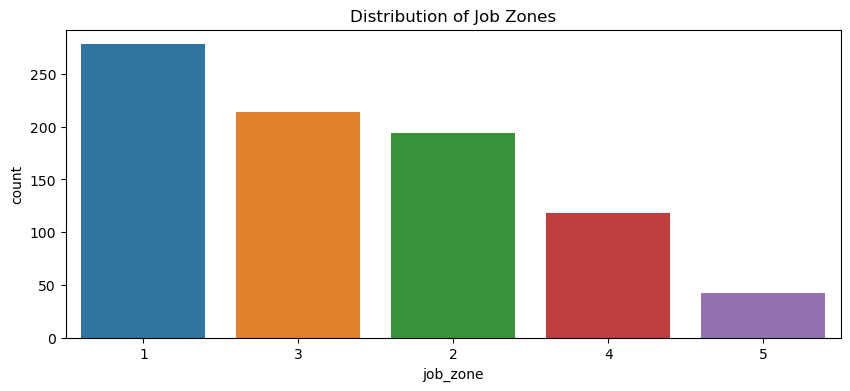

Zone 3:  Most occupations in this zone require training in vocational schools, related on-the-job experience, or an associate's degree.
Zone 1:  These occupations usually require a high school diploma.
Zone 4:  Most of these occupations require graduate school. For example, they may require a master's degree, and some require a Ph.D., M.D., or J.D. (law degree).
Zone 2:  Most of these occupations require a four-year bachelor's degree, but some do not.
Zone 5:  Some of these occupations may require a high school diploma or GED certificate.


In [23]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='job_zone', order = df['job_zone'].value_counts().index)
plt.title('Distribution of Job Zones')
plt.show()

for i, row in job_zone.iterrows():
    print(f"Zone {row['job_zone_id']}:  {row['education']}")

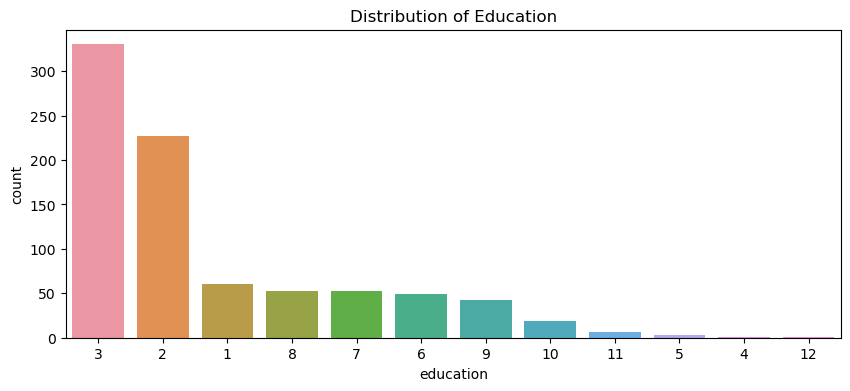

8:  Post-secondary certificate
9:  Doctoral degree
11:  Post-doctoral training
2:  Bachelor's degree
1:  Less than high school diploma
5:  Professional degree
3:  High school diploma or equivalent
7:  Master's degree
10:  Some college, no degree
4:  Post-baccalaureate certificate
6:  Associate's degree
12:  Post-master's certificate


In [24]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='education', order = df['education'].value_counts().index)
plt.title('Distribution of Education')
plt.show()

for i, row in education.iterrows():
    print(f"{row['education_id']}:  {row['name']}")